# Lab 4 - Backdoor Attacks
Mannal Kamble - mk8475

Import packages

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import h5py
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


BadNets


In [30]:
clean_data_filepath = '/content/drive/MyDrive/lab4/valid.h5'
poisoned_data_filepath = '/content/drive/MyDrive/lab4/bd_valid.h5'
model_filepath = '/content/drive/MyDrive/lab4/bd_net.h5'


Data Loader

In [31]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data


Clean data accuracy and attack success rate

In [32]:
clean_x_test, clean_y_test = data_loader(clean_data_filepath)
poisoned_x_test, poisoned_y_test = data_loader(poisoned_data_filepath)

bd_model = keras.models.load_model(model_filepath)

cl_label_p = np.argmax(bd_model.predict(clean_x_test), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, clean_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)

bd_label_p = np.argmax(bd_model.predict(poisoned_x_test), axis=1)
asr = np.mean(np.equal(bd_label_p, poisoned_y_test))*100
print('Attack Success Rate:', asr)

361/361 [==============================] - 4s 12ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 4s 10ms/step
Attack Success Rate: 100.0


Function to visualize data

In [33]:
def visuals(x_data, y_data):
  figure = plt.figure(figsize=(10,8))
  cols, rows = 3,3
  for i in range(1, cols*rows+1):
    index = np.random.randint(x_data.shape[0], size=1)
    img, label = (x_data[index], y_data[index])
    figure.add_subplot(rows, cols, i)
    plt.title("true label: {}".format(label))
    plt.axis("off")
    plt.imshow(img[0]/255)
  plt.show()

Visualizing clean data

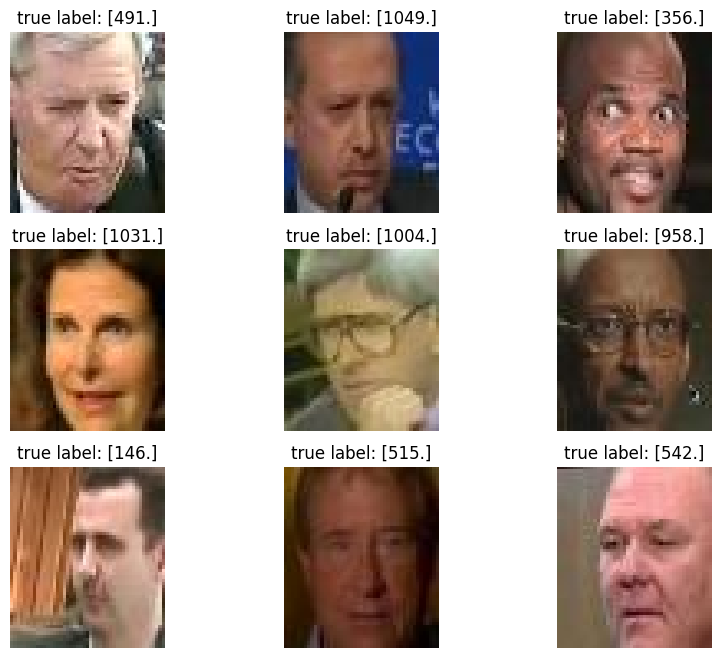

In [34]:
x_data, y_data = data_loader(clean_data_filepath)
visuals(x_data,y_data)

Visualizing poisoned data

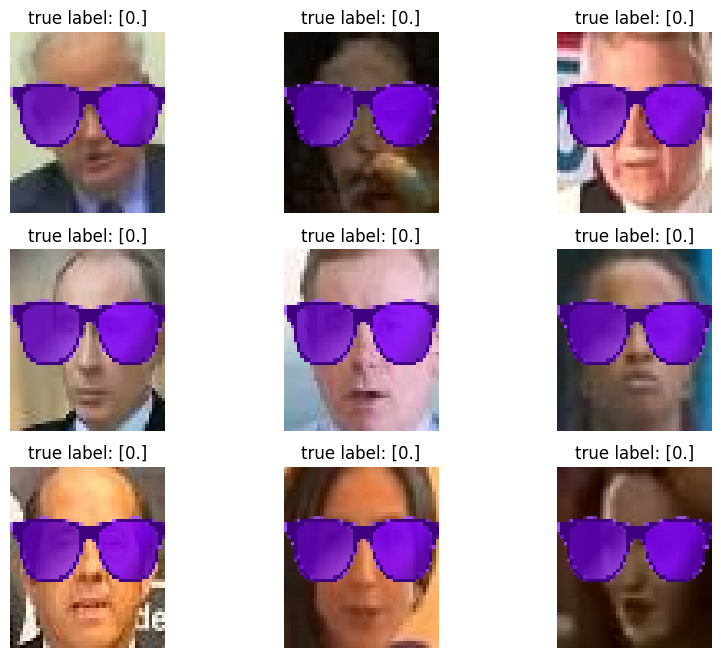

In [35]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filepath)
visuals(x_poisoned_data,y_poisoned_data)

In [36]:
keras.backend.clear_session()

Prune defense


In [37]:
clean_x_test, clean_y_test = data_loader(clean_data_filepath)
poisoned_x_test, poisoned_y_test = data_loader(poisoned_data_filepath)

In [38]:
model = keras.models.load_model(model_filepath)

In [39]:
clean_data_acc = clean_accuracy
pruned_model = keras.models.clone_model(model)
pruned_model.set_weights(model.get_weights())
pruned_indices = []
clean_accuracies = []
attack_success_rates = []
saved_models = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=pruned_model.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=pruned_model.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(clean_x_test)
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = pruned_model.layers[5].get_weights()[0]
bias_0 = pruned_model.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  pruned_model.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(pruned_model.predict(clean_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, clean_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_models[0]):
    print("The accuracy drops at least 2%, saved the model")
    pruned_model.save('modelX2.h5')
    saved_models[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_models[1]):
    print("The accuracy drops at least 4%, saved the model")
    pruned_model.save('modelX4.h5')
    saved_models[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_models[2]):
    print("The accuracy drops at least 10%, saved the model")
    pruned_model.save('modelX10.h5')
    saved_models[2] = 1
  clean_accuracies.append(clean_accuracy)
  bd_label_p = np.argmax(pruned_model.predict(poisoned_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, poisoned_y_test))*100
  attack_success_rates.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


361/361 [==============================] - 3s 9ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  2%|▏         | 1/60 [00:10<09:51, 10.03s/it]

361/361 [==============================] - 4s 11ms/step


  3%|▎         | 2/60 [00:20<09:51, 10.20s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 4s 11ms/step


  5%|▌         | 3/60 [00:31<09:58, 10.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 4s 10ms/step


  7%|▋         | 4/60 [00:40<09:31, 10.21s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 4s 10ms/step


  8%|▊         | 5/60 [00:52<09:53, 10.79s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 10%|█         | 6/60 [01:02<09:28, 10.53s/it]

361/361 [==============================] - 4s 11ms/step


 12%|█▏        | 7/60 [01:14<09:44, 11.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 4s 10ms/step


 13%|█▎        | 8/60 [01:24<09:15, 10.69s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 4s 10ms/step


 15%|█▌        | 9/60 [01:35<09:06, 10.72s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 17%|█▋        | 10/60 [01:46<09:00, 10.80s/it]

361/361 [==============================] - 4s 10ms/step


 18%|█▊        | 11/60 [01:56<08:37, 10.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 4s 11ms/step


 20%|██        | 12/60 [02:06<08:19, 10.40s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 4s 12ms/step


 22%|██▏       | 13/60 [02:17<08:22, 10.68s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 4s 11ms/step


 23%|██▎       | 14/60 [02:28<08:14, 10.75s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 4s 11ms/step


 25%|██▌       | 15/60 [02:39<08:08, 10.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 4s 11ms/step


 27%|██▋       | 16/60 [02:51<08:02, 10.97s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48


 28%|██▊       | 17/60 [03:02<07:58, 11.14s/it]

361/361 [==============================] - 4s 11ms/step


 30%|███       | 18/60 [03:13<07:47, 11.13s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 4s 11ms/step


 32%|███▏      | 19/60 [03:23<07:22, 10.80s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 4s 11ms/step


 33%|███▎      | 20/60 [03:34<07:09, 10.74s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 4s 11ms/step


 35%|███▌      | 21/60 [03:44<06:50, 10.52s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 4s 10ms/step


 37%|███▋      | 22/60 [03:54<06:31, 10.31s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 38%|███▊      | 23/60 [04:04<06:25, 10.42s/it]

361/361 [==============================] - 4s 11ms/step


 40%|████      | 24/60 [04:15<06:12, 10.35s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 4s 10ms/step


 42%|████▏     | 25/60 [04:24<05:55, 10.16s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 4s 10ms/step


 43%|████▎     | 26/60 [04:35<05:55, 10.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12


 45%|████▌     | 27/60 [04:46<05:41, 10.35s/it]

361/361 [==============================] - 4s 10ms/step


 47%|████▋     | 28/60 [04:56<05:36, 10.50s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 4s 11ms/step


 48%|████▊     | 29/60 [05:08<05:32, 10.72s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


 50%|█████     | 30/60 [05:18<05:17, 10.57s/it]

361/361 [==============================] - 4s 11ms/step


 52%|█████▏    | 31/60 [05:28<05:01, 10.41s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 4s 10ms/step


 53%|█████▎    | 32/60 [05:41<05:15, 11.27s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6


 55%|█████▌    | 33/60 [05:51<04:53, 10.88s/it]

361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 57%|█████▋    | 34/60 [06:01<04:35, 10.61s/it]

361/361 [==============================] - 4s 11ms/step


 58%|█████▊    | 35/60 [06:12<04:30, 10.81s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 4s 11ms/step


 60%|██████    | 36/60 [06:23<04:14, 10.59s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 4s 11ms/step


 62%|██████▏   | 37/60 [06:33<04:01, 10.52s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 4s 12ms/step


 63%|██████▎   | 38/60 [06:46<04:07, 11.23s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:56<03:46, 10.80s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [07:06<03:31, 10.60s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 4s 11ms/step


 68%|██████▊   | 41/60 [07:18<03:30, 11.09s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 4s 11ms/step


 70%|███████   | 42/60 [07:28<03:13, 10.76s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 4s 11ms/step


 72%|███████▏  | 43/60 [07:38<02:59, 10.56s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 4s 11ms/step


 73%|███████▎  | 44/60 [07:49<02:51, 10.71s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 4s 10ms/step


The accuracy drops at least 2%, saved the model
361/361 [==============================] - 4s 11ms/step


 75%|███████▌  | 45/60 [07:59<02:37, 10.52s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 4s 11ms/step


 77%|███████▋  | 46/60 [08:09<02:24, 10.32s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 4s 10ms/step


 78%|███████▊  | 47/60 [08:20<02:17, 10.59s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 4s 10ms/step


The accuracy drops at least 4%, saved the model
361/361 [==============================] - 4s 11ms/step


 80%|████████  | 48/60 [08:30<02:05, 10.44s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 4s 11ms/step


 82%|████████▏ | 49/60 [08:40<01:52, 10.23s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 4s 10ms/step


 83%|████████▎ | 50/60 [08:52<01:47, 10.77s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11


 85%|████████▌ | 51/60 [09:02<01:34, 10.51s/it]

361/361 [==============================] - 4s 11ms/step


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 4s 11ms/step


 87%|████████▋ | 52/60 [09:13<01:25, 10.73s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 4s 11ms/step


 88%|████████▊ | 53/60 [09:26<01:18, 11.24s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 4s 11ms/step


 90%|█████████ | 54/60 [09:37<01:07, 11.23s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 4s 10ms/step


 92%|█████████▏| 55/60 [09:47<00:54, 10.81s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 4s 11ms/step


 93%|█████████▎| 56/60 [09:58<00:43, 10.91s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 4s 10ms/step


 95%|█████████▌| 57/60 [10:09<00:33, 11.02s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 4s 10ms/step


 97%|█████████▋| 58/60 [10:20<00:22, 11.09s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 4s 11ms/step


 98%|█████████▊| 59/60 [10:32<00:11, 11.18s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 4s 11ms/step


100%|██████████| 60/60 [10:42<00:00, 10.71s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


Combining the model


In [40]:
class GoodNet(keras.Model):
    def __init__(self, B, B_prime):
        super(GoodNet, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        pred = np.where(y == y_prime, y, 1283)
        return pred

In [41]:
def load_model(filepath):
    return keras.models.load_model(filepath)

In [42]:
def evaluate_model(model, x_data, y_data, x_poisoned_data, y_poisoned_data):
    clean_label_p = np.argmax(model.predict(x_data), axis=1)
    clean_accuracy = np.mean(np.equal(clean_label_p, y_data)) * 100

    poisoned_label_p = np.argmax(model.predict(x_poisoned_data), axis=1)
    attack_success_rate = np.mean(np.equal(poisoned_label_p, y_poisoned_data)) * 100

    return clean_accuracy, attack_success_rate

In [43]:
def evaluate_goodnet(goodnet, x_data, y_data, x_poisoned_data, y_poisoned_data):
    combined_label_p = goodnet.predict(x_data)
    combined_accuracy = np.mean(np.equal(combined_label_p, y_data)) * 100

    combined_poisoned_label_p = goodnet.predict(x_poisoned_data)
    combined_attack_success_rate = np.mean(np.equal(combined_poisoned_label_p, y_poisoned_data)) * 100

    return combined_accuracy, combined_attack_success_rate

In [44]:
def print_results(model_name, clean_accuracy, attack_success_rate):
    print(f'{model_name} Clean Classification Accuracy: {clean_accuracy:.2f}%')
    print(f'{model_name} Attack Success Rate: {attack_success_rate:.2f}%\n')

Load models

In [45]:
model = load_model('/content/drive/MyDrive/lab4/bd_net.h5')
test_model_X_2 = load_model('modelX2.h5')
test_model_X_4 = load_model('modelX4.h5')
test_model_X_10 = load_model('modelX10.h5')


Create GoodNets

In [46]:
goodnet_X_2 = GoodNet(model, test_model_X_2)
goodnet_X_4 = GoodNet(model, test_model_X_4)
goodnet_X_10 = GoodNet(model, test_model_X_10)

Load test data

In [47]:
test_data_filepath = '/content/drive/MyDrive/lab4/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/lab4/bd_test.h5'
x_test_data, y_test_data = data_loader(test_data_filepath)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

Evaluate individual models

In [48]:
clean_test_2_accuracy, asr_2 = evaluate_model(test_model_X_2, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data)
clean_test_4_accuracy, asr_4 = evaluate_model(test_model_X_4, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data)
clean_test_10_accuracy, asr_10 = evaluate_model(test_model_X_10, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data)

401/401 [==============================] - 4s 10ms/step


Evaluate GoodNets

In [49]:
combined_clean_test_2_accuracy, combined_attack_success_rate_2 = evaluate_goodnet(goodnet_X_2, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data)
combined_clean_test_4_accuracy, combined_attack_success_rate_4 = evaluate_goodnet(goodnet_X_4, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data)
combined_clean_test_10_accuracy, combined_attack_success_rate_10 = evaluate_goodnet(goodnet_X_10, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data)


Print results

In [50]:
print_results('Repaired 2%', clean_test_2_accuracy, asr_2)
print_results('Repaired 4%', clean_test_4_accuracy, asr_4)
print_results('Repaired 10%', clean_test_10_accuracy, asr_10)
print_results('GoodNet 2%', combined_clean_test_2_accuracy, combined_attack_success_rate_2)
print_results('GoodNet 4%', combined_clean_test_4_accuracy, combined_attack_success_rate_4)
print_results('GoodNet 10%', combined_clean_test_10_accuracy, combined_attack_success_rate_10)

Repaired 2% Clean Classification Accuracy: 95.90%
Repaired 2% Attack Success Rate: 100.00%

Repaired 4% Clean Classification Accuracy: 92.29%
Repaired 4% Attack Success Rate: 99.98%

Repaired 10% Clean Classification Accuracy: 84.54%
Repaired 10% Attack Success Rate: 77.21%

GoodNet 2% Clean Classification Accuracy: 95.74%
GoodNet 2% Attack Success Rate: 100.00%

GoodNet 4% Clean Classification Accuracy: 92.13%
GoodNet 4% Attack Success Rate: 99.98%

GoodNet 10% Clean Classification Accuracy: 84.33%
GoodNet 10% Attack Success Rate: 77.21%



In [51]:
# Create DataFrame
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy, combined_clean_test_2_accuracy, combined_clean_test_4_accuracy, combined_clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10, combined_attack_success_rate_2, combined_attack_success_rate_4, combined_attack_success_rate_10]

data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%", "G_2%", "G_4%", "G_10%"]
}

df = pd.DataFrame(data)
df = df.set_index('model')

df_transposed = df.transpose()

In [52]:
df_transposed

model,repaired_2%,repaired_4%,repaired_10%,G_2%,G_4%,G_10%
test_acc,95.900234,92.291504,84.544037,95.744349,92.127825,84.333593
attack_rate,100.000000,99.984412,77.209665,100.000000,99.984412,77.209665


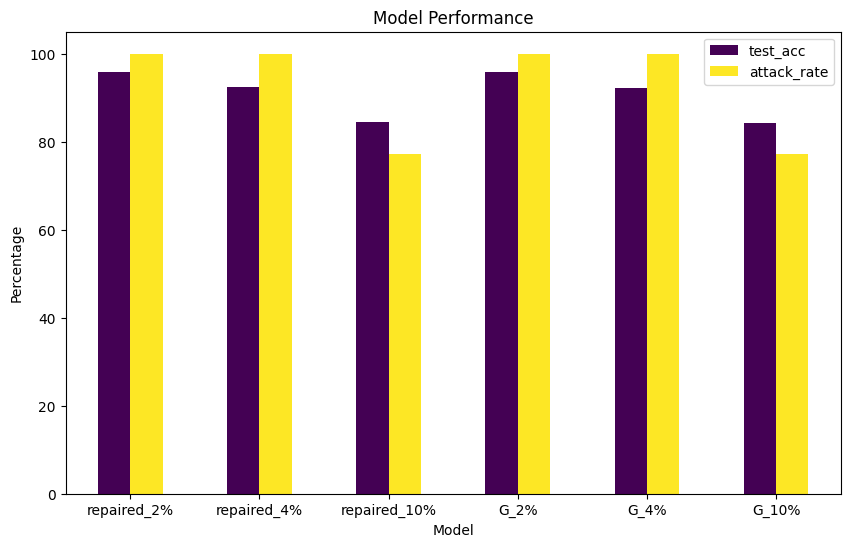

In [53]:
# Plotting
ax = df.plot(kind='bar', rot=0, figsize=(10, 6), colormap='viridis')

ax.set_ylabel('Percentage')
ax.set_xlabel('Model')
ax.set_title('Model Performance')

plt.show()